<a href="https://colab.research.google.com/github/plaban1981/Pytorch/blob/master/pytorch_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch: Training your first Convolutional Neural Network (CNN)


### Download the code zip file

In [ ]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/pytorch-cnn/pytorch-cnn.zip
!unzip -qq pytorch-cnn.zip
%cd pytorch-cnn

### Import Packages

In [ ]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch import flatten
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

### Implementing a Convolutional Neural Network (CNN) with PyTorch

* The constructor to your Module only initializes your layer types. 

* PyTorch keeps track of these variables, but it has no idea how the layers connect to each other.

* The forward function helps PyTorch to understand the network architecture.

* The  variables defined are initialized and connected inside the forward function of the  constructor .

* PyTorch can then make predictions using your network and perform automatic backpropagation, using the autograd module

In [ ]:
class LeNet(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()

		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=800, out_features=500)
		self.relu3 = ReLU()

		# initialize our softmax classifier
		self.fc2 = Linear(in_features=500, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)

	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)

		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)

		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)

		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)

		# return the output predictions
		return output

#### The constructor to LeNet accepts two variables:

* **numChannels:** 1 for grayscale or 3 for RGB
* **classes:** Total number of unique class labels in our dataset

To build the network architecture we need to override the forward method of the Module class.

The forward function serves a number of purposes:

* It connects layers/subnetworks together from variables defined in the constructor (i.e., __init__) of the class
* It defines the network architecture itself
* It allows the forward pass of the model to be performed, resulting in our output predictions
* PyTorch’s autograd module, it allows us to perform automatic differentiation and update our model weights

### Creating our CNN training script with PyTorch


In [ ]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10

# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## KMNIST Data 
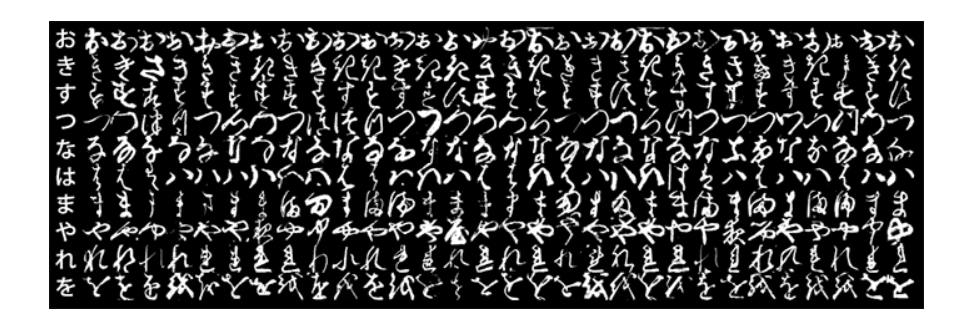

##Torch datasets

In [ ]:
# load the KMNIST dataset
print("[INFO] loading the KMNIST dataset...")
trainData = KMNIST(root="data", train=True, download=True,transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True,transform=ToTensor())

# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

In [ ]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [ ]:
# initialize the LeNet model
print("[INFO] initializing the LeNet model...")
model = LeNet(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)

# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()

# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

In [ ]:
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

# loop over our epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0

	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))

		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)

		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

	# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()

		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))

			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)

			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

In [ ]:
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")

# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []

	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)

		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())

# generate a classification report
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

## Save the model

In [ ]:
# serialize the model to disk
torch.save(model, "model.pth")

## Make predictions on a sample of our testing set:

In [ ]:
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
import cv2
import imutils
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
%matplotlib inline

In [ ]:
testData = KMNIST(root="data", train=False, download=True,transform=ToTensor())
idxs = np.random.choice(range(0, len(testData)), size=(10,))
testData = Subset(testData, idxs)
# initialize the test data loader
testDataLoader = DataLoader(testData, batch_size=1)
# load the model and set it to evaluation mode
model = torch.load("model.pth").to(device)
model.eval()

In [ ]:
with torch.no_grad():
	# loop over the test set
	for (image, label) in testDataLoader:
		# grab the original image and ground truth label
		origImage = image.numpy().squeeze(axis=(0, 1))
		gtLabel = testData.dataset.classes[label.numpy()[0]]

		# send the input to the device and make predictions on it
		image = image.to(device)
		pred = model(image)

		# find the class label index with the largest corresponding
		# probability
		idx = pred.argmax(axis=1).cpu().numpy()[0]
		predLabel = testData.dataset.classes[idx]

		# convert the image from grayscale to RGB (so we can draw on
		# it) and resize it (so we can more easily see it on our
		# screen)
		origImage = np.dstack([origImage] * 3)
		origImage = imutils.resize(origImage, width=128)

		# draw the predicted class label on it
		color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
		cv2.putText(origImage, gtLabel, (2, 25),
			cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

		# display the result in terminal and show the input image
		print("[INFO] ground truth label: {}, predicted label: {}".format(gtLabel, predLabel))
		cv2_imshow(origImage)

In [ ]:
with torch.no_grad():
  for image,label in testDataLoader:
    # retrieve original image and label
    #print(type(image))
    origImage = image.numpy() 
    print(origImage.shape)
    #origImage = origImage.reshape(-1,28,28,1)
    print(origImage.shape)
    #print(label.numpy())
    #print(trainData.dataset.classes)
    gtLabel = trainData.dataset.classes[label.numpy()[0]]
    # send the input to the device and make predictions on it
    image = image.to(device)
    pred = model(image)
    # find the class label probability
    idx = pred.argmax(axis=1).cpu().numpy()[0]
    predLabel = trainData.dataset.classes[idx]
    ## convert the image from grayscale to RGB
    origImage = cv2.cvtColor(origImage,cv2.COLOR_GRAY2RGB)
    origImage = cv2.resize(origImage, (224,224))

    #origImage = imutils.resize(origImage, width=128) 
    if gtLabel == predLabel:
      color = (0, 255, 0)
    else:
      color = (0, 0, 255)
    print(origImage.shape)
    cv2.putText(origImage, gtLabel, (2, 25),cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
		# display the result in terminal and show the input image
    print("[INFO] ground truth label: {}, predicted label: {}".format(gtLabel, predLabel))
    cv2_imshow(origImage)


